In [1]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader, DirectoryLoader
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import StrOutputParser
from langchain.schema import Document
from langgraph.graph import START, StateGraph, END
from typing import Literal, List
from typing_extensions import TypedDict
from dotenv import load_dotenv
from PIL import Image
import json
import os

c:\a\envs\env2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\a\envs\env2\lib\site-packages\IPython\core\interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
load_dotenv()
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
llm = ChatGoogleGenerativeAI(api_key = GOOGLE_API_KEY, model = "gemini-1.5-flash",temperature = 0.1)

In [3]:
llm.invoke("hello").content

'Hello there! How can I help you today?\n'

In [71]:
class GraphState(TypedDict):
    result : str  
    doc : str  

In [72]:
def pdf_extractor(state):
    doc = state["doc"]
    loader = DirectoryLoader(r"C:\Projects\Research-Paper-Evaluater\data\\", glob="*.pdf", loader_cls=PyPDFLoader)
    documents = loader.load()
    all_text = " ".join([doc.page_content for doc in documents])

    return {"doc" : all_text}

In [73]:
def report_decider(state):
    doc = state["doc"]
    print(doc[:100]) 
    
    class decide(BaseModel):
        Binary_Score: str = Field(..., description="Is this Report Publishable?, respond with Yes or No.")
    
    structured_llm = llm.with_structured_output(decide)
    
    system = """
    You are an AI system tasked with determining whether a given document is a publishable research paper. A publishable research paper must meet the following criteria:

    1. Structure:
    - The document includes a title, abstract, introduction, methodology, results, discussion, and references.
    
    2. **Content**:
    - The document presents original research, analysis, or findings.
    - It has a clear research question, hypothesis, or objective.
    - The methodology is well-detailed and appropriate for the research question.
    - Results are presented with supporting data, graphs, or tables.

    3. **Language and Formatting**:
    - The writing is clear, concise, and follows academic standards.
    - Proper citations and references are included in a recognized citation style.

    4. **Credibility**:
    - Sources cited in the references are credible and relevant to the topic.
    - The claims made are supported by sufficient evidence.

    Your task is to analyze the provided document and respond with "Yes" if it meets these criteria for publication or "No" if it does not.

    Document: {doc}
    """  
    
    binary_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", f"paper: {doc}")
        ]
    )
    
    grader_chain = binary_prompt | structured_llm
    
    llm_response = grader_chain.invoke({"doc": doc})  # Pass the correct key
    print("Detecting Report")
    
    if llm_response.Binary_Score == "Yes":
        return {"result": "Yes"}
    else:
        return {"result": "No"}


In [74]:
workflow = StateGraph(GraphState)

workflow.add_node("PDF_Extractor", pdf_extractor)
workflow.add_node("Report_Generator", report_decider)

# workflow.add_edge(START, "PDF_Extractor")
workflow.add_edge(START, "Report_Generator")
workflow.add_edge("Report_Generator", END)

app = workflow.compile()

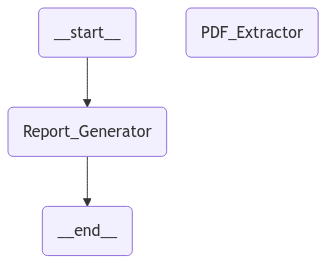

In [75]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
loader = DirectoryLoader(r"C:\Projects\Research-Paper-Evaluater\data\\", glob="*.pdf", loader_cls=PyPDFLoader)
documents = loader.load()

all_text = " ".join([doc.page_content for doc in documents])

print("First 200 characters of the document text:")
print(all_text[:200])

sanitized_text = all_text.replace("{", "{{").replace("}", "}}")

if not sanitized_text.strip():
    print("The document is empty or malformed.")
else:
    inputs = {"doc": sanitized_text}

    final_output = None 
    for output in app.stream(inputs):
        final_output = output 
        for key, value in output.items():
            print(f"Node '{key}': {value}")
        print("\n---\n")

    if final_output and "result" in final_output:
        pprint(final_output["result"])
    else:
        print("No result produced.")


First 200 characters of the document text:
Examining the Convergence of Denoising Diffusion Probabilistic
Models: A Quantitative Analysis
Abstract
Deep generative models, particularly diffusion models, are a significant family within deep lear
Examining the Convergence of Denoising Diffusion Probabilistic
Models: A Quantitative Analysis
Abstr
Detecting Report
Node 'Report_Generator': {'result': 'Yes'}

---

No result produced.
